<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE1] - First VAE, with a small dataset (MNIST)
<!-- DESC --> Construction and training of a VAE with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example.  
François Chollet is not only the author of Keras and a great guru, he is also a sorcerer ;-)  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from IPython.display import display,Image,Markdown,HTML

from modules.VAE          import VAE, Sampling
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/MNIST.001'                     # Output directory
datasets_dir = pwk.init('VAE1', run_dir)

VAE.about()

**\*\* Overrided parameters : \*\***

run_dir              : ./run/VAE1_done


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.14
Notebook id          : VAE1
Run time             : Wednesday 10 February 2021, 11:00:23
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/VAE1_done
Update keras cache   : False
Save figs            : True
Path figs            : ./run/VAE1_done/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.2
TensorFlow version   : 2.4.0
Keras version        : 2.4.0


## Step 2 - Parameters
Uncomment the right lines according to what you want.

In [2]:
# ---- Smart tests
#
latent_dim    = 2
r_loss_factor = 0.994
scale         = 0.1
batch_size    = 64
epochs        = 10

# ---- Full run (1'30 on a V100)
#
# latent_dim    = 2
# r_loss_factor = 0.994
# scale         = 1.
# batch_size    = 64
# epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'latent_dim', 'r_loss_factor', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

scale                : 1
latent_dim           : 2
r_loss_factor        : 0.994
batch_size           : 64
epochs               : 10


## Step 3 - Prepare data
### 3.1 - Get it

In [4]:
x_train, _ = Loader_MNIST.get()
np.random.shuffle(x_train)
nb_images = int(len(x_train)*scale)
x_train   = x_train[:nb_images]
print('\nTrain shape after rescale : ',x_train.shape)

Dataset loaded.
Normalized.
Expanded.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)



Train shape after rescale :  (70000, 28, 28, 1)


### 3.2 - Have a look

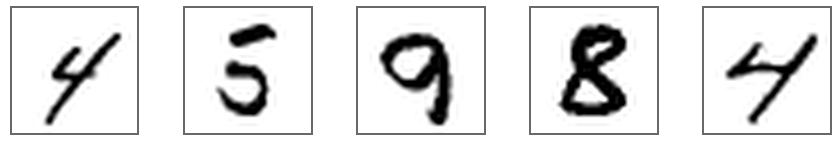

In [5]:
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=3,y_size=2, save_as='01-original')

## Step 4 - Build model

#### Encoder

In [6]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [7]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### VAE
Our loss function is the weighted sum of two values.  
`reconstruction_loss` which measures the loss during reconstruction.  
`kl_loss` which measures the dispersion.  

The weights are defined by: `r_loss_factor` :  
`total_loss = r_loss_factor*reconstruction_loss + (1-r_loss_factor)*kl_loss`

if `r_loss_factor = 1`, the loss function includes only `reconstruction_loss`  
if `r_loss_factor = 0`, the loss function includes only `kl_loss`  
In practice, a value of 0.3 gives good results here.


In [8]:
vae = VAE(encoder, decoder, r_loss_factor)

vae.compile(optimizer=keras.optimizers.Adam())

Init VAE, with r_loss_factor=0.994


## Step 5 - Train
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
# ---- Callback : Images encoded
pwk.mkdir(run_dir + '/images-encoded')
filename = run_dir + '/images-encoded/image-{epoch:03d}-{i:02d}.jpg'
callback_images1 = ImagesCallback(filename, x=x_train[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Images generated
pwk.mkdir(run_dir + '/images-generated')
filename = run_dir + '/images-generated/image-{epoch:03d}-{i:02d}.jpg'
callback_images2 = ImagesCallback(filename, x=None, nb_images=5, z_dim=2, encoder=encoder,decoder=decoder)          

# ---- Callback : Best model
pwk.mkdir(run_dir + '/models')
filename = run_dir + '/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

# callbacks_list = [callback_images1, callback_images2, callback_bestmodel, callback_tensorboard]
callbacks_list = [callback_images1, callback_images2, callback_bestmodel]

In [10]:
pwk.chrono_start()

history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10


   1/1094 [..............................] - ETA: 1:07:00 - loss: 0.6893 - r_loss: 0.6934 - kl_loss: 8.6029e-04

  12/1094 [..............................] - ETA: 4s - loss: 0.6505 - r_loss: 0.6539 - kl_loss: 0.0941         

  24/1094 [..............................] - ETA: 4s - loss: 0.5570 - r_loss: 0.5581 - kl_loss: 0.3598

  36/1094 [..............................] - ETA: 4s - loss: 0.4946 - r_loss: 0.4962 - kl_loss: 0.2424

  48/1094 [>.............................] - ETA: 4s - loss: 0.4433 - r_loss: 0.4445 - kl_loss: 0.2351

  60/1094 [>.............................] - ETA: 4s - loss: 0.4091 - r_loss: 0.4102 - kl_loss: 0.2315

  72/1094 [>.............................] - ETA: 4s - loss: 0.3861 - r_loss: 0.3872 - kl_loss: 0.1965

  84/1094 [=>............................] - ETA: 4s - loss: 0.3697 - r_loss: 0.3709 - kl_loss: 0.1718

  96/1094 [=>............................] - ETA: 4s - loss: 0.3568 - r_loss: 0.3580 - kl_loss: 0.1535

 108/1094 [=>............................] - ETA: 4s - loss: 0.3465 - r_loss: 0.3478 - kl_loss: 0.1397

 120/1094 [==>...........................] - ETA: 4s - loss: 0.3381 - r_loss: 0.3393 - kl_loss: 0.1401

 132/1094 [==>...........................] - ETA: 4s - loss: 0.3311 - r_loss: 0.3321 - kl_loss: 0.1722

 144/1094 [==>...........................] - ETA: 4s - loss: 0.3250 - r_loss: 0.3257 - kl_loss: 0.2119

 156/1094 [===>..........................] - ETA: 4s - loss: 0.3192 - r_loss: 0.3196 - kl_loss: 0.2535

 168/1094 [===>..........................] - ETA: 4s - loss: 0.3139 - r_loss: 0.3140 - kl_loss: 0.3035

 180/1094 [===>..........................] - ETA: 3s - loss: 0.3092 - r_loss: 0.3089 - kl_loss: 0.3611

 192/1094 [====>.........................] - ETA: 3s - loss: 0.3049 - r_loss: 0.3043 - kl_loss: 0.4164

 204/1094 [====>.........................] - ETA: 3s - loss: 0.3009 - r_loss: 0.2999 - kl_loss: 0.4705

 216/1094 [====>.........................] - ETA: 3s - loss: 0.2971 - r_loss: 0.2958 - kl_loss: 0.5189

 228/1094 [=====>........................] - ETA: 3s - loss: 0.2939 - r_loss: 0.2922 - kl_loss: 0.5691

 240/1094 [=====>........................] - ETA: 3s - loss: 0.2906 - r_loss: 0.2886 - kl_loss: 0.6164

 252/1094 [=====>........................] - ETA: 3s - loss: 0.2878 - r_loss: 0.2856 - kl_loss: 0.6559

 264/1094 [======>.......................] - ETA: 3s - loss: 0.2851 - r_loss: 0.2826 - kl_loss: 0.7010

 276/1094 [======>.......................] - ETA: 3s - loss: 0.2826 - r_loss: 0.2799 - kl_loss: 0.7404

 288/1094 [======>.......................] - ETA: 3s - loss: 0.2805 - r_loss: 0.2775 - kl_loss: 0.7774

 300/1094 [=======>......................] - ETA: 3s - loss: 0.2785 - r_loss: 0.2753 - kl_loss: 0.8129

 312/1094 [=======>......................] - ETA: 3s - loss: 0.2764 - r_loss: 0.2729 - kl_loss: 0.8481

 324/1094 [=======>......................] - ETA: 3s - loss: 0.2744 - r_loss: 0.2707 - kl_loss: 0.8814

 336/1094 [========>.....................] - ETA: 3s - loss: 0.2727 - r_loss: 0.2688 - kl_loss: 0.9097

 348/1094 [========>.....................] - ETA: 3s - loss: 0.2709 - r_loss: 0.2669 - kl_loss: 0.9406

 360/1094 [========>.....................] - ETA: 3s - loss: 0.2692 - r_loss: 0.2650 - kl_loss: 0.9659

 372/1094 [=========>....................] - ETA: 3s - loss: 0.2676 - r_loss: 0.2633 - kl_loss: 0.9933

 384/1094 [=========>....................] - ETA: 3s - loss: 0.2663 - r_loss: 0.2617 - kl_loss: 1.0212

 396/1094 [=========>....................] - ETA: 3s - loss: 0.2649 - r_loss: 0.2601 - kl_loss: 1.0454

 408/1094 [==========>...................] - ETA: 2s - loss: 0.2636 - r_loss: 0.2587 - kl_loss: 1.0702

 420/1094 [==========>...................] - ETA: 2s - loss: 0.2623 - r_loss: 0.2573 - kl_loss: 1.0942

 432/1094 [==========>...................] - ETA: 2s - loss: 0.2611 - r_loss: 0.2559 - kl_loss: 1.1148

 444/1094 [===========>..................] - ETA: 2s - loss: 0.2600 - r_loss: 0.2547 - kl_loss: 1.1352

 456/1094 [===========>..................] - ETA: 2s - loss: 0.2588 - r_loss: 0.2534 - kl_loss: 1.1552

 468/1094 [===========>..................] - ETA: 2s - loss: 0.2578 - r_loss: 0.2522 - kl_loss: 1.1747

 480/1094 [============>.................] - ETA: 2s - loss: 0.2568 - r_loss: 0.2511 - kl_loss: 1.1935

 492/1094 [============>.................] - ETA: 2s - loss: 0.2558 - r_loss: 0.2501 - kl_loss: 1.2116

 504/1094 [============>.................] - ETA: 2s - loss: 0.2550 - r_loss: 0.2491 - kl_loss: 1.2296

 516/1094 [=============>................] - ETA: 2s - loss: 0.2540 - r_loss: 0.2480 - kl_loss: 1.2462

 528/1094 [=============>................] - ETA: 2s - loss: 0.2531 - r_loss: 0.2470 - kl_loss: 1.2637

 540/1094 [=============>................] - ETA: 2s - loss: 0.2524 - r_loss: 0.2462 - kl_loss: 1.2799

 552/1094 [==============>...............] - ETA: 2s - loss: 0.2516 - r_loss: 0.2453 - kl_loss: 1.2954

 564/1094 [==============>...............] - ETA: 2s - loss: 0.2507 - r_loss: 0.2443 - kl_loss: 1.3117

 576/1094 [==============>...............] - ETA: 2s - loss: 0.2500 - r_loss: 0.2435 - kl_loss: 1.3255

 588/1094 [===============>..............] - ETA: 2s - loss: 0.2494 - r_loss: 0.2428 - kl_loss: 1.3395

 600/1094 [===============>..............] - ETA: 2s - loss: 0.2487 - r_loss: 0.2420 - kl_loss: 1.3532

 612/1094 [===============>..............] - ETA: 2s - loss: 0.2480 - r_loss: 0.2413 - kl_loss: 1.3674

 624/1094 [================>.............] - ETA: 2s - loss: 0.2473 - r_loss: 0.2405 - kl_loss: 1.3794

 636/1094 [================>.............] - ETA: 1s - loss: 0.2467 - r_loss: 0.2398 - kl_loss: 1.3922

 648/1094 [================>.............] - ETA: 1s - loss: 0.2461 - r_loss: 0.2391 - kl_loss: 1.4051

 660/1094 [=================>............] - ETA: 1s - loss: 0.2455 - r_loss: 0.2384 - kl_loss: 1.4174

 672/1094 [=================>............] - ETA: 1s - loss: 0.2448 - r_loss: 0.2377 - kl_loss: 1.4291

 684/1094 [=================>............] - ETA: 1s - loss: 0.2443 - r_loss: 0.2371 - kl_loss: 1.4382

 696/1094 [==================>...........] - ETA: 1s - loss: 0.2438 - r_loss: 0.2365 - kl_loss: 1.4508

 708/1094 [==================>...........] - ETA: 1s - loss: 0.2433 - r_loss: 0.2359 - kl_loss: 1.4610

 720/1094 [==================>...........] - ETA: 1s - loss: 0.2428 - r_loss: 0.2354 - kl_loss: 1.4708

 732/1094 [===================>..........] - ETA: 1s - loss: 0.2423 - r_loss: 0.2348 - kl_loss: 1.4803

 744/1094 [===================>..........] - ETA: 1s - loss: 0.2418 - r_loss: 0.2343 - kl_loss: 1.4896

 756/1094 [===================>..........] - ETA: 1s - loss: 0.2413 - r_loss: 0.2337 - kl_loss: 1.4986

 768/1094 [====================>.........] - ETA: 1s - loss: 0.2409 - r_loss: 0.2332 - kl_loss: 1.5086

 780/1094 [====================>.........] - ETA: 1s - loss: 0.2403 - r_loss: 0.2326 - kl_loss: 1.5180

 792/1094 [====================>.........] - ETA: 1s - loss: 0.2398 - r_loss: 0.2321 - kl_loss: 1.5263

 804/1094 [=====================>........] - ETA: 1s - loss: 0.2394 - r_loss: 0.2316 - kl_loss: 1.5354

 816/1094 [=====================>........] - ETA: 1s - loss: 0.2390 - r_loss: 0.2311 - kl_loss: 1.5439

 828/1094 [=====================>........] - ETA: 1s - loss: 0.2386 - r_loss: 0.2307 - kl_loss: 1.5525

 840/1094 [======================>.......] - ETA: 1s - loss: 0.2382 - r_loss: 0.2302 - kl_loss: 1.5611

 852/1094 [======================>.......] - ETA: 1s - loss: 0.2378 - r_loss: 0.2298 - kl_loss: 1.5677

 864/1094 [======================>.......] - ETA: 0s - loss: 0.2375 - r_loss: 0.2294 - kl_loss: 1.5764

 876/1094 [=======================>......] - ETA: 0s - loss: 0.2371 - r_loss: 0.2290 - kl_loss: 1.5833

 888/1094 [=======================>......] - ETA: 0s - loss: 0.2367 - r_loss: 0.2285 - kl_loss: 1.5911

 900/1094 [=======================>......] - ETA: 0s - loss: 0.2363 - r_loss: 0.2281 - kl_loss: 1.5983

 912/1094 [========================>.....] - ETA: 0s - loss: 0.2360 - r_loss: 0.2277 - kl_loss: 1.6056

 924/1094 [========================>.....] - ETA: 0s - loss: 0.2357 - r_loss: 0.2274 - kl_loss: 1.6119

 936/1094 [========================>.....] - ETA: 0s - loss: 0.2354 - r_loss: 0.2270 - kl_loss: 1.6196

 948/1094 [========================>.....] - ETA: 0s - loss: 0.2350 - r_loss: 0.2266 - kl_loss: 1.6273

 960/1094 [=========================>....] - ETA: 0s - loss: 0.2347 - r_loss: 0.2262 - kl_loss: 1.6336

 972/1094 [=========================>....] - ETA: 0s - loss: 0.2344 - r_loss: 0.2259 - kl_loss: 1.6399

 984/1094 [=========================>....] - ETA: 0s - loss: 0.2341 - r_loss: 0.2255 - kl_loss: 1.6464

 996/1094 [==========================>...] - ETA: 0s - loss: 0.2338 - r_loss: 0.2253 - kl_loss: 1.6522

1008/1094 [==========================>...] - ETA: 0s - loss: 0.2335 - r_loss: 0.2249 - kl_loss: 1.6590

1020/1094 [==========================>...] - ETA: 0s - loss: 0.2332 - r_loss: 0.2246 - kl_loss: 1.6642

1032/1094 [===========================>..] - ETA: 0s - loss: 0.2330 - r_loss: 0.2243 - kl_loss: 1.6705

1044/1094 [===========================>..] - ETA: 0s - loss: 0.2327 - r_loss: 0.2240 - kl_loss: 1.6761

1056/1094 [===========================>..] - ETA: 0s - loss: 0.2324 - r_loss: 0.2237 - kl_loss: 1.6816

1068/1094 [============================>.] - ETA: 0s - loss: 0.2322 - r_loss: 0.2234 - kl_loss: 1.6878

1080/1094 [============================>.] - ETA: 0s - loss: 0.2319 - r_loss: 0.2231 - kl_loss: 1.6930

1092/1094 [============================>.] - ETA: 0s - loss: 0.2316 - r_loss: 0.2228 - kl_loss: 1.6983

1094/1094 [==============================] - ETA: 0s - loss: 0.2316 - r_loss: 0.2227 - kl_loss: 1.6994

1094/1094 [==============================] - 8s 4ms/step - loss: 0.2316 - r_loss: 0.2227 - kl_loss: 1.7001


Saved - loss=0.214132
Epoch 2/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2164 - r_loss: 0.2041 - kl_loss: 2.2665

  13/1094 [..............................] - ETA: 4s - loss: 0.2067 - r_loss: 0.1949 - kl_loss: 2.1644

  25/1094 [..............................] - ETA: 4s - loss: 0.2073 - r_loss: 0.1951 - kl_loss: 2.2308

  37/1094 [>.............................] - ETA: 4s - loss: 0.2066 - r_loss: 0.1945 - kl_loss: 2.2121

  49/1094 [>.............................] - ETA: 4s - loss: 0.2075 - r_loss: 0.1954 - kl_loss: 2.2077

  61/1094 [>.............................] - ETA: 4s - loss: 0.2074 - r_loss: 0.1952 - kl_loss: 2.2167

  73/1094 [=>............................] - ETA: 4s - loss: 0.2075 - r_loss: 0.1953 - kl_loss: 2.2245

  85/1094 [=>............................] - ETA: 4s - loss: 0.2076 - r_loss: 0.1954 - kl_loss: 2.2210

  97/1094 [=>............................] - ETA: 4s - loss: 0.2078 - r_loss: 0.1956 - kl_loss: 2.2207

 109/1094 [=>............................] - ETA: 4s - loss: 0.2072 - r_loss: 0.1949 - kl_loss: 2.2339

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2069 - r_loss: 0.1947 - kl_loss: 2.2327

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2068 - r_loss: 0.1946 - kl_loss: 2.2324

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2069 - r_loss: 0.1946 - kl_loss: 2.2347

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2067 - r_loss: 0.1944 - kl_loss: 2.2384

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2072 - r_loss: 0.1949 - kl_loss: 2.2339

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2072 - r_loss: 0.1950 - kl_loss: 2.2317

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2069 - r_loss: 0.1947 - kl_loss: 2.2300

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2070 - r_loss: 0.1948 - kl_loss: 2.2311

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2067 - r_loss: 0.1945 - kl_loss: 2.2328

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2066 - r_loss: 0.1944 - kl_loss: 2.2342

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2068 - r_loss: 0.1945 - kl_loss: 2.2350

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2068 - r_loss: 0.1945 - kl_loss: 2.2366

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2067 - r_loss: 0.1945 - kl_loss: 2.2337

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2067 - r_loss: 0.1944 - kl_loss: 2.2347

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2067 - r_loss: 0.1945 - kl_loss: 2.2346

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2067 - r_loss: 0.1944 - kl_loss: 2.2349

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2067 - r_loss: 0.1944 - kl_loss: 2.2389

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2066 - r_loss: 0.1943 - kl_loss: 2.2405

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2068 - r_loss: 0.1945 - kl_loss: 2.2394

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2067 - r_loss: 0.1944 - kl_loss: 2.2409

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2067 - r_loss: 0.1944 - kl_loss: 2.2479

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2066 - r_loss: 0.1943 - kl_loss: 2.2473

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2066 - r_loss: 0.1943 - kl_loss: 2.2469

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2066 - r_loss: 0.1943 - kl_loss: 2.2483

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2067 - r_loss: 0.1944 - kl_loss: 2.2484

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2066 - r_loss: 0.1942 - kl_loss: 2.2512

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2066 - r_loss: 0.1942 - kl_loss: 2.2525

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2066 - r_loss: 0.1942 - kl_loss: 2.2560

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2066 - r_loss: 0.1942 - kl_loss: 2.2542

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2065 - r_loss: 0.1942 - kl_loss: 2.2569

 481/1094 [============>.................] - ETA: 2s - loss: 0.2065 - r_loss: 0.1941 - kl_loss: 2.2585

 493/1094 [============>.................] - ETA: 2s - loss: 0.2065 - r_loss: 0.1941 - kl_loss: 2.2591

 505/1094 [============>.................] - ETA: 2s - loss: 0.2065 - r_loss: 0.1941 - kl_loss: 2.2603

 517/1094 [=============>................] - ETA: 2s - loss: 0.2064 - r_loss: 0.1940 - kl_loss: 2.2612

 529/1094 [=============>................] - ETA: 2s - loss: 0.2064 - r_loss: 0.1940 - kl_loss: 2.2628

 541/1094 [=============>................] - ETA: 2s - loss: 0.2064 - r_loss: 0.1939 - kl_loss: 2.2645

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2063 - r_loss: 0.1939 - kl_loss: 2.2650

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2063 - r_loss: 0.1938 - kl_loss: 2.2657

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2062 - r_loss: 0.1938 - kl_loss: 2.2674

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2062 - r_loss: 0.1938 - kl_loss: 2.2684

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2062 - r_loss: 0.1937 - kl_loss: 2.2683

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2061 - r_loss: 0.1937 - kl_loss: 2.2695

 625/1094 [================>.............] - ETA: 2s - loss: 0.2061 - r_loss: 0.1937 - kl_loss: 2.2699

 637/1094 [================>.............] - ETA: 1s - loss: 0.2060 - r_loss: 0.1936 - kl_loss: 2.2726

 649/1094 [================>.............] - ETA: 1s - loss: 0.2060 - r_loss: 0.1936 - kl_loss: 2.2730

 661/1094 [=================>............] - ETA: 1s - loss: 0.2060 - r_loss: 0.1935 - kl_loss: 2.2748

 673/1094 [=================>............] - ETA: 1s - loss: 0.2059 - r_loss: 0.1934 - kl_loss: 2.2771

 685/1094 [=================>............] - ETA: 1s - loss: 0.2059 - r_loss: 0.1934 - kl_loss: 2.2778

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2059 - r_loss: 0.1934 - kl_loss: 2.2794

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2058 - r_loss: 0.1933 - kl_loss: 2.2786

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2058 - r_loss: 0.1933 - kl_loss: 2.2804

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2058 - r_loss: 0.1933 - kl_loss: 2.2818

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2058 - r_loss: 0.1932 - kl_loss: 2.2835

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2057 - r_loss: 0.1932 - kl_loss: 2.2846

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2057 - r_loss: 0.1931 - kl_loss: 2.2856

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2058 - r_loss: 0.1932 - kl_loss: 2.2855

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2058 - r_loss: 0.1932 - kl_loss: 2.2863

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2057 - r_loss: 0.1932 - kl_loss: 2.2868

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2057 - r_loss: 0.1931 - kl_loss: 2.2885

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2056 - r_loss: 0.1930 - kl_loss: 2.2893

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2056 - r_loss: 0.1930 - kl_loss: 2.2897

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2056 - r_loss: 0.1930 - kl_loss: 2.2915

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2055 - r_loss: 0.1929 - kl_loss: 2.2925

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2055 - r_loss: 0.1929 - kl_loss: 2.2941

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2055 - r_loss: 0.1929 - kl_loss: 2.2951

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2054 - r_loss: 0.1928 - kl_loss: 2.2962

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2054 - r_loss: 0.1928 - kl_loss: 2.2959

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2054 - r_loss: 0.1928 - kl_loss: 2.2968

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2054 - r_loss: 0.1928 - kl_loss: 2.2967

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2054 - r_loss: 0.1927 - kl_loss: 2.2985

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2053 - r_loss: 0.1927 - kl_loss: 2.2997

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2053 - r_loss: 0.1926 - kl_loss: 2.3009

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2052 - r_loss: 0.1925 - kl_loss: 2.3025

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2052 - r_loss: 0.1925 - kl_loss: 2.3035

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2051 - r_loss: 0.1925 - kl_loss: 2.3038

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2051 - r_loss: 0.1924 - kl_loss: 2.3048

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2050 - r_loss: 0.1923 - kl_loss: 2.3061

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2050 - r_loss: 0.1923 - kl_loss: 2.3072

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2049 - r_loss: 0.1922 - kl_loss: 2.3080

1069/1094 [============================>.] - ETA: 0s - loss: 0.2049 - r_loss: 0.1922 - kl_loss: 2.3089

1081/1094 [============================>.] - ETA: 0s - loss: 0.2049 - r_loss: 0.1921 - kl_loss: 2.3101

1093/1094 [============================>.] - ETA: 0s - loss: 0.2048 - r_loss: 0.1921 - kl_loss: 2.3117

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2048 - r_loss: 0.1921 - kl_loss: 2.3122


Saved - loss=0.201457
Epoch 3/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2010 - r_loss: 0.1875 - kl_loss: 2.4410

  13/1094 [..............................] - ETA: 4s - loss: 0.2019 - r_loss: 0.1887 - kl_loss: 2.3878

  25/1094 [..............................] - ETA: 4s - loss: 0.2036 - r_loss: 0.1902 - kl_loss: 2.4195

  37/1094 [>.............................] - ETA: 4s - loss: 0.2049 - r_loss: 0.1916 - kl_loss: 2.4104

  49/1094 [>.............................] - ETA: 4s - loss: 0.2039 - r_loss: 0.1906 - kl_loss: 2.4176

  61/1094 [>.............................] - ETA: 4s - loss: 0.2034 - r_loss: 0.1901 - kl_loss: 2.4091

  73/1094 [=>............................] - ETA: 4s - loss: 0.2032 - r_loss: 0.1899 - kl_loss: 2.4084

  85/1094 [=>............................] - ETA: 4s - loss: 0.2037 - r_loss: 0.1904 - kl_loss: 2.4038

  97/1094 [=>............................] - ETA: 4s - loss: 0.2037 - r_loss: 0.1905 - kl_loss: 2.3985

 109/1094 [=>............................] - ETA: 4s - loss: 0.2033 - r_loss: 0.1900 - kl_loss: 2.4051

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2032 - r_loss: 0.1899 - kl_loss: 2.4088

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2030 - r_loss: 0.1897 - kl_loss: 2.4022

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2030 - r_loss: 0.1897 - kl_loss: 2.4041

 157/1094 [===>..........................] - ETA: 4s - loss: 0.2028 - r_loss: 0.1895 - kl_loss: 2.4071

 169/1094 [===>..........................] - ETA: 4s - loss: 0.2024 - r_loss: 0.1891 - kl_loss: 2.4073

 181/1094 [===>..........................] - ETA: 3s - loss: 0.2023 - r_loss: 0.1891 - kl_loss: 2.4047

 193/1094 [====>.........................] - ETA: 3s - loss: 0.2025 - r_loss: 0.1892 - kl_loss: 2.4061

 205/1094 [====>.........................] - ETA: 3s - loss: 0.2024 - r_loss: 0.1891 - kl_loss: 2.4050

 217/1094 [====>.........................] - ETA: 3s - loss: 0.2025 - r_loss: 0.1892 - kl_loss: 2.4041

 229/1094 [=====>........................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4068

 241/1094 [=====>........................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1889 - kl_loss: 2.4059

 253/1094 [=====>........................] - ETA: 3s - loss: 0.2022 - r_loss: 0.1888 - kl_loss: 2.4100

 265/1094 [======>.......................] - ETA: 3s - loss: 0.2019 - r_loss: 0.1886 - kl_loss: 2.4120

 277/1094 [======>.......................] - ETA: 3s - loss: 0.2018 - r_loss: 0.1885 - kl_loss: 2.4127

 289/1094 [======>.......................] - ETA: 3s - loss: 0.2019 - r_loss: 0.1885 - kl_loss: 2.4114

 301/1094 [=======>......................] - ETA: 3s - loss: 0.2019 - r_loss: 0.1885 - kl_loss: 2.4140

 313/1094 [=======>......................] - ETA: 3s - loss: 0.2019 - r_loss: 0.1885 - kl_loss: 2.4168

 325/1094 [=======>......................] - ETA: 3s - loss: 0.2019 - r_loss: 0.1885 - kl_loss: 2.4177

 337/1094 [========>.....................] - ETA: 3s - loss: 0.2018 - r_loss: 0.1884 - kl_loss: 2.4181

 349/1094 [========>.....................] - ETA: 3s - loss: 0.2017 - r_loss: 0.1883 - kl_loss: 2.4190

 361/1094 [========>.....................] - ETA: 3s - loss: 0.2016 - r_loss: 0.1882 - kl_loss: 2.4202

 373/1094 [=========>....................] - ETA: 3s - loss: 0.2015 - r_loss: 0.1882 - kl_loss: 2.4186

 385/1094 [=========>....................] - ETA: 3s - loss: 0.2015 - r_loss: 0.1881 - kl_loss: 2.4193

 397/1094 [=========>....................] - ETA: 3s - loss: 0.2016 - r_loss: 0.1882 - kl_loss: 2.4189

 409/1094 [==========>...................] - ETA: 2s - loss: 0.2016 - r_loss: 0.1882 - kl_loss: 2.4201

 421/1094 [==========>...................] - ETA: 2s - loss: 0.2015 - r_loss: 0.1881 - kl_loss: 2.4226

 433/1094 [==========>...................] - ETA: 2s - loss: 0.2014 - r_loss: 0.1880 - kl_loss: 2.4236

 445/1094 [===========>..................] - ETA: 2s - loss: 0.2013 - r_loss: 0.1879 - kl_loss: 2.4246

 457/1094 [===========>..................] - ETA: 2s - loss: 0.2013 - r_loss: 0.1879 - kl_loss: 2.4239

 469/1094 [===========>..................] - ETA: 2s - loss: 0.2013 - r_loss: 0.1879 - kl_loss: 2.4255

 481/1094 [============>.................] - ETA: 2s - loss: 0.2013 - r_loss: 0.1879 - kl_loss: 2.4255

 493/1094 [============>.................] - ETA: 2s - loss: 0.2014 - r_loss: 0.1879 - kl_loss: 2.4271

 505/1094 [============>.................] - ETA: 2s - loss: 0.2014 - r_loss: 0.1880 - kl_loss: 2.4262

 517/1094 [=============>................] - ETA: 2s - loss: 0.2014 - r_loss: 0.1879 - kl_loss: 2.4302

 529/1094 [=============>................] - ETA: 2s - loss: 0.2014 - r_loss: 0.1880 - kl_loss: 2.4301

 541/1094 [=============>................] - ETA: 2s - loss: 0.2013 - r_loss: 0.1878 - kl_loss: 2.4297

 553/1094 [==============>...............] - ETA: 2s - loss: 0.2012 - r_loss: 0.1877 - kl_loss: 2.4318

 565/1094 [==============>...............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1877 - kl_loss: 2.4330

 577/1094 [==============>...............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4342

 589/1094 [===============>..............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4348

 601/1094 [===============>..............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4349

 613/1094 [===============>..............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1877 - kl_loss: 2.4355

 625/1094 [================>.............] - ETA: 2s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4375

 637/1094 [================>.............] - ETA: 1s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4384

 649/1094 [================>.............] - ETA: 1s - loss: 0.2012 - r_loss: 0.1877 - kl_loss: 2.4386

 661/1094 [=================>............] - ETA: 1s - loss: 0.2010 - r_loss: 0.1875 - kl_loss: 2.4394

 673/1094 [=================>............] - ETA: 1s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4393

 685/1094 [=================>............] - ETA: 1s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4382

 697/1094 [==================>...........] - ETA: 1s - loss: 0.2012 - r_loss: 0.1876 - kl_loss: 2.4388

 709/1094 [==================>...........] - ETA: 1s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4394

 721/1094 [==================>...........] - ETA: 1s - loss: 0.2012 - r_loss: 0.1876 - kl_loss: 2.4397

 733/1094 [===================>..........] - ETA: 1s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4400

 745/1094 [===================>..........] - ETA: 1s - loss: 0.2012 - r_loss: 0.1876 - kl_loss: 2.4410

 757/1094 [===================>..........] - ETA: 1s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4415

 769/1094 [====================>.........] - ETA: 1s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4433

 781/1094 [====================>.........] - ETA: 1s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4426

 793/1094 [====================>.........] - ETA: 1s - loss: 0.2011 - r_loss: 0.1876 - kl_loss: 2.4428

 805/1094 [=====================>........] - ETA: 1s - loss: 0.2011 - r_loss: 0.1875 - kl_loss: 2.4438

 817/1094 [=====================>........] - ETA: 1s - loss: 0.2011 - r_loss: 0.1875 - kl_loss: 2.4448

 829/1094 [=====================>........] - ETA: 1s - loss: 0.2011 - r_loss: 0.1875 - kl_loss: 2.4450

 841/1094 [======================>.......] - ETA: 1s - loss: 0.2010 - r_loss: 0.1875 - kl_loss: 2.4453

 853/1094 [======================>.......] - ETA: 1s - loss: 0.2011 - r_loss: 0.1875 - kl_loss: 2.4456

 865/1094 [======================>.......] - ETA: 0s - loss: 0.2010 - r_loss: 0.1875 - kl_loss: 2.4463

 877/1094 [=======================>......] - ETA: 0s - loss: 0.2011 - r_loss: 0.1875 - kl_loss: 2.4466

 889/1094 [=======================>......] - ETA: 0s - loss: 0.2011 - r_loss: 0.1875 - kl_loss: 2.4475

 901/1094 [=======================>......] - ETA: 0s - loss: 0.2010 - r_loss: 0.1875 - kl_loss: 2.4482

 913/1094 [========================>.....] - ETA: 0s - loss: 0.2011 - r_loss: 0.1875 - kl_loss: 2.4485

 925/1094 [========================>.....] - ETA: 0s - loss: 0.2011 - r_loss: 0.1875 - kl_loss: 2.4495

 937/1094 [========================>.....] - ETA: 0s - loss: 0.2011 - r_loss: 0.1875 - kl_loss: 2.4496

 949/1094 [=========================>....] - ETA: 0s - loss: 0.2011 - r_loss: 0.1875 - kl_loss: 2.4495

 961/1094 [=========================>....] - ETA: 0s - loss: 0.2010 - r_loss: 0.1874 - kl_loss: 2.4501

 973/1094 [=========================>....] - ETA: 0s - loss: 0.2010 - r_loss: 0.1874 - kl_loss: 2.4509

 985/1094 [==========================>...] - ETA: 0s - loss: 0.2010 - r_loss: 0.1874 - kl_loss: 2.4516

 997/1094 [==========================>...] - ETA: 0s - loss: 0.2009 - r_loss: 0.1874 - kl_loss: 2.4518

1009/1094 [==========================>...] - ETA: 0s - loss: 0.2009 - r_loss: 0.1873 - kl_loss: 2.4521

1021/1094 [==========================>...] - ETA: 0s - loss: 0.2009 - r_loss: 0.1873 - kl_loss: 2.4530

1033/1094 [===========================>..] - ETA: 0s - loss: 0.2008 - r_loss: 0.1872 - kl_loss: 2.4532

1045/1094 [===========================>..] - ETA: 0s - loss: 0.2008 - r_loss: 0.1872 - kl_loss: 2.4534

1057/1094 [===========================>..] - ETA: 0s - loss: 0.2008 - r_loss: 0.1872 - kl_loss: 2.4541

1069/1094 [============================>.] - ETA: 0s - loss: 0.2008 - r_loss: 0.1872 - kl_loss: 2.4546

1081/1094 [============================>.] - ETA: 0s - loss: 0.2007 - r_loss: 0.1871 - kl_loss: 2.4542

1093/1094 [============================>.] - ETA: 0s - loss: 0.2007 - r_loss: 0.1871 - kl_loss: 2.4548

1094/1094 [==============================] - 5s 4ms/step - loss: 0.2007 - r_loss: 0.1871 - kl_loss: 2.4552


Epoch 4/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1936 - r_loss: 0.1794 - kl_loss: 2.5468

  13/1094 [..............................] - ETA: 4s - loss: 0.1988 - r_loss: 0.1850 - kl_loss: 2.4814

  25/1094 [..............................] - ETA: 4s - loss: 0.1962 - r_loss: 0.1822 - kl_loss: 2.5134

  37/1094 [>.............................] - ETA: 4s - loss: 0.1964 - r_loss: 0.1823 - kl_loss: 2.5279

  49/1094 [>.............................] - ETA: 4s - loss: 0.1970 - r_loss: 0.1829 - kl_loss: 2.5281

  61/1094 [>.............................] - ETA: 4s - loss: 0.1971 - r_loss: 0.1830 - kl_loss: 2.5349

  73/1094 [=>............................] - ETA: 4s - loss: 0.1978 - r_loss: 0.1837 - kl_loss: 2.5253

  85/1094 [=>............................] - ETA: 4s - loss: 0.1976 - r_loss: 0.1836 - kl_loss: 2.5193

  97/1094 [=>............................] - ETA: 4s - loss: 0.1975 - r_loss: 0.1836 - kl_loss: 2.5085

 109/1094 [=>............................] - ETA: 4s - loss: 0.1975 - r_loss: 0.1836 - kl_loss: 2.5066

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1978 - r_loss: 0.1839 - kl_loss: 2.5040

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5065

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1980 - r_loss: 0.1841 - kl_loss: 2.5049

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1984 - r_loss: 0.1845 - kl_loss: 2.5021

 169/1094 [===>..........................] - ETA: 3s - loss: 0.1981 - r_loss: 0.1841 - kl_loss: 2.5074

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1983 - r_loss: 0.1844 - kl_loss: 2.5079

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1982 - r_loss: 0.1843 - kl_loss: 2.5079

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1985 - r_loss: 0.1846 - kl_loss: 2.5063

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1985 - r_loss: 0.1846 - kl_loss: 2.5049

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1987 - r_loss: 0.1848 - kl_loss: 2.5049

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1987 - r_loss: 0.1848 - kl_loss: 2.5030

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1987 - r_loss: 0.1848 - kl_loss: 2.5056

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1987 - r_loss: 0.1847 - kl_loss: 2.5081

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1987 - r_loss: 0.1847 - kl_loss: 2.5102

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1988 - r_loss: 0.1848 - kl_loss: 2.5134

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1987 - r_loss: 0.1848 - kl_loss: 2.5137

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1985 - r_loss: 0.1845 - kl_loss: 2.5148

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1984 - r_loss: 0.1844 - kl_loss: 2.5161

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5173

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1982 - r_loss: 0.1842 - kl_loss: 2.5180

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1982 - r_loss: 0.1842 - kl_loss: 2.5172

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1982 - r_loss: 0.1842 - kl_loss: 2.5190

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1982 - r_loss: 0.1842 - kl_loss: 2.5177

 397/1094 [=========>....................] - ETA: 2s - loss: 0.1984 - r_loss: 0.1844 - kl_loss: 2.5182

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5192

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1983 - r_loss: 0.1842 - kl_loss: 2.5188

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5205

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5215

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1985 - r_loss: 0.1844 - kl_loss: 2.5219

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1985 - r_loss: 0.1845 - kl_loss: 2.5220

 481/1094 [============>.................] - ETA: 2s - loss: 0.1985 - r_loss: 0.1845 - kl_loss: 2.5205

 493/1094 [============>.................] - ETA: 2s - loss: 0.1985 - r_loss: 0.1845 - kl_loss: 2.5208

 505/1094 [============>.................] - ETA: 2s - loss: 0.1986 - r_loss: 0.1845 - kl_loss: 2.5207

 517/1094 [=============>................] - ETA: 2s - loss: 0.1985 - r_loss: 0.1845 - kl_loss: 2.5210

 529/1094 [=============>................] - ETA: 2s - loss: 0.1984 - r_loss: 0.1844 - kl_loss: 2.5200

 541/1094 [=============>................] - ETA: 2s - loss: 0.1984 - r_loss: 0.1844 - kl_loss: 2.5212

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1985 - r_loss: 0.1844 - kl_loss: 2.5212

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1984 - r_loss: 0.1844 - kl_loss: 2.5208

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1984 - r_loss: 0.1844 - kl_loss: 2.5204

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5208

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1984 - r_loss: 0.1844 - kl_loss: 2.5202

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1984 - r_loss: 0.1844 - kl_loss: 2.5208

 625/1094 [================>.............] - ETA: 2s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5205

 637/1094 [================>.............] - ETA: 1s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5213

 649/1094 [================>.............] - ETA: 1s - loss: 0.1984 - r_loss: 0.1843 - kl_loss: 2.5222

 661/1094 [=================>............] - ETA: 1s - loss: 0.1984 - r_loss: 0.1844 - kl_loss: 2.5214

 673/1094 [=================>............] - ETA: 1s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5224

 685/1094 [=================>............] - ETA: 1s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5225

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5230

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5239

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5241

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5247

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1984 - r_loss: 0.1843 - kl_loss: 2.5253

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5247

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5257

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1984 - r_loss: 0.1843 - kl_loss: 2.5257

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5256

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1983 - r_loss: 0.1843 - kl_loss: 2.5251

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1983 - r_loss: 0.1842 - kl_loss: 2.5263

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1842 - kl_loss: 2.5272

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1982 - r_loss: 0.1842 - kl_loss: 2.5267

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5288

 865/1094 [======================>.......] - ETA: 0s - loss: 0.1982 - r_loss: 0.1842 - kl_loss: 2.5287

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5285

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5287

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1982 - r_loss: 0.1842 - kl_loss: 2.5284

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5299

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5307

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1981 - r_loss: 0.1841 - kl_loss: 2.5320

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5321

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5324

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5338

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1981 - r_loss: 0.1840 - kl_loss: 2.5330

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1981 - r_loss: 0.1840 - kl_loss: 2.5326

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1981 - r_loss: 0.1840 - kl_loss: 2.5332

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1981 - r_loss: 0.1840 - kl_loss: 2.5328

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5341

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5345

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5354

1069/1094 [============================>.] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5353

1081/1094 [============================>.] - ETA: 0s - loss: 0.1982 - r_loss: 0.1840 - kl_loss: 2.5360

1093/1094 [============================>.] - ETA: 0s - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5358

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1982 - r_loss: 0.1841 - kl_loss: 2.5358


Epoch 5/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2032 - r_loss: 0.1887 - kl_loss: 2.5950

  13/1094 [..............................] - ETA: 4s - loss: 0.1999 - r_loss: 0.1855 - kl_loss: 2.5855

  25/1094 [..............................] - ETA: 4s - loss: 0.1970 - r_loss: 0.1824 - kl_loss: 2.6171

  37/1094 [>.............................] - ETA: 4s - loss: 0.1974 - r_loss: 0.1829 - kl_loss: 2.6117

  49/1094 [>.............................] - ETA: 4s - loss: 0.1964 - r_loss: 0.1819 - kl_loss: 2.5908

  61/1094 [>.............................] - ETA: 4s - loss: 0.1976 - r_loss: 0.1832 - kl_loss: 2.5907

  73/1094 [=>............................] - ETA: 4s - loss: 0.1978 - r_loss: 0.1833 - kl_loss: 2.5932

  85/1094 [=>............................] - ETA: 4s - loss: 0.1982 - r_loss: 0.1838 - kl_loss: 2.5877

  97/1094 [=>............................] - ETA: 4s - loss: 0.1978 - r_loss: 0.1833 - kl_loss: 2.5843

 109/1094 [=>............................] - ETA: 4s - loss: 0.1981 - r_loss: 0.1837 - kl_loss: 2.5815

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1982 - r_loss: 0.1838 - kl_loss: 2.5809

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1983 - r_loss: 0.1839 - kl_loss: 2.5768

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1981 - r_loss: 0.1837 - kl_loss: 2.5741

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1980 - r_loss: 0.1837 - kl_loss: 2.5664

 169/1094 [===>..........................] - ETA: 3s - loss: 0.1977 - r_loss: 0.1834 - kl_loss: 2.5710

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1976 - r_loss: 0.1833 - kl_loss: 2.5757

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1976 - r_loss: 0.1832 - kl_loss: 2.5737

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1831 - kl_loss: 2.5718

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1830 - kl_loss: 2.5737

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1829 - kl_loss: 2.5743

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1829 - kl_loss: 2.5730

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1973 - r_loss: 0.1829 - kl_loss: 2.5763

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1831 - kl_loss: 2.5759

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1974 - r_loss: 0.1831 - kl_loss: 2.5750

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1972 - r_loss: 0.1828 - kl_loss: 2.5779

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5792

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1827 - kl_loss: 2.5776

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5781

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1971 - r_loss: 0.1827 - kl_loss: 2.5795

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5792

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5782

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1826 - kl_loss: 2.5780

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5783

 397/1094 [=========>....................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5787

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5796

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5787

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5787

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1969 - r_loss: 0.1826 - kl_loss: 2.5775

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5765

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5773

 481/1094 [============>.................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5773

 493/1094 [============>.................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5782

 505/1094 [============>.................] - ETA: 2s - loss: 0.1970 - r_loss: 0.1826 - kl_loss: 2.5780

 517/1094 [=============>................] - ETA: 2s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5784

 529/1094 [=============>................] - ETA: 2s - loss: 0.1968 - r_loss: 0.1824 - kl_loss: 2.5796

 541/1094 [=============>................] - ETA: 2s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5804

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5808

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1969 - r_loss: 0.1825 - kl_loss: 2.5802

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1968 - r_loss: 0.1824 - kl_loss: 2.5803

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1968 - r_loss: 0.1824 - kl_loss: 2.5811

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1967 - r_loss: 0.1823 - kl_loss: 2.5807

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1966 - r_loss: 0.1822 - kl_loss: 2.5817

 625/1094 [================>.............] - ETA: 2s - loss: 0.1967 - r_loss: 0.1823 - kl_loss: 2.5824

 637/1094 [================>.............] - ETA: 1s - loss: 0.1966 - r_loss: 0.1823 - kl_loss: 2.5818

 649/1094 [================>.............] - ETA: 1s - loss: 0.1966 - r_loss: 0.1822 - kl_loss: 2.5825

 661/1094 [=================>............] - ETA: 1s - loss: 0.1966 - r_loss: 0.1822 - kl_loss: 2.5836

 673/1094 [=================>............] - ETA: 1s - loss: 0.1966 - r_loss: 0.1822 - kl_loss: 2.5831

 685/1094 [=================>............] - ETA: 1s - loss: 0.1966 - r_loss: 0.1822 - kl_loss: 2.5838

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5838

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1966 - r_loss: 0.1822 - kl_loss: 2.5825

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5831

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5824

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5835

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5842

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5840

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5839

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5835

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5847

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5840

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1964 - r_loss: 0.1820 - kl_loss: 2.5836

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1964 - r_loss: 0.1820 - kl_loss: 2.5843

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5846

 865/1094 [======================>.......] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5851

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1965 - r_loss: 0.1820 - kl_loss: 2.5854

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5849

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5851

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5854

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5862

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5861

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5860

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5867

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1964 - r_loss: 0.1820 - kl_loss: 2.5869

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5861

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5870

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5874

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5877

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5875

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5882

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5883

1069/1094 [============================>.] - ETA: 0s - loss: 0.1965 - r_loss: 0.1821 - kl_loss: 2.5882

1081/1094 [============================>.] - ETA: 0s - loss: 0.1965 - r_loss: 0.1820 - kl_loss: 2.5882

1093/1094 [============================>.] - ETA: 0s - loss: 0.1965 - r_loss: 0.1820 - kl_loss: 2.5883

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1964 - r_loss: 0.1820 - kl_loss: 2.5883


Saved - loss=0.185337
Epoch 6/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2029 - r_loss: 0.1888 - kl_loss: 2.5286

  13/1094 [..............................] - ETA: 4s - loss: 0.1968 - r_loss: 0.1825 - kl_loss: 2.5670

  25/1094 [..............................] - ETA: 4s - loss: 0.1981 - r_loss: 0.1834 - kl_loss: 2.6263

  37/1094 [>.............................] - ETA: 4s - loss: 0.1973 - r_loss: 0.1827 - kl_loss: 2.6113

  49/1094 [>.............................] - ETA: 4s - loss: 0.1976 - r_loss: 0.1830 - kl_loss: 2.6212

  61/1094 [>.............................] - ETA: 4s - loss: 0.1972 - r_loss: 0.1826 - kl_loss: 2.6083

  73/1094 [=>............................] - ETA: 4s - loss: 0.1972 - r_loss: 0.1827 - kl_loss: 2.6003

  85/1094 [=>............................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1820 - kl_loss: 2.6075

  97/1094 [=>............................] - ETA: 4s - loss: 0.1964 - r_loss: 0.1817 - kl_loss: 2.6171

 109/1094 [=>............................] - ETA: 4s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6155

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1957 - r_loss: 0.1811 - kl_loss: 2.6165

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6152

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1966 - r_loss: 0.1820 - kl_loss: 2.6140

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1968 - r_loss: 0.1822 - kl_loss: 2.6141

 169/1094 [===>..........................] - ETA: 3s - loss: 0.1969 - r_loss: 0.1824 - kl_loss: 2.6114

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1970 - r_loss: 0.1824 - kl_loss: 2.6135

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6149

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1968 - r_loss: 0.1822 - kl_loss: 2.6160

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1966 - r_loss: 0.1820 - kl_loss: 2.6196

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1965 - r_loss: 0.1819 - kl_loss: 2.6171

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1965 - r_loss: 0.1819 - kl_loss: 2.6195

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1967 - r_loss: 0.1821 - kl_loss: 2.6208

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1964 - r_loss: 0.1817 - kl_loss: 2.6228

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1963 - r_loss: 0.1816 - kl_loss: 2.6229

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1963 - r_loss: 0.1816 - kl_loss: 2.6240

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6205

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6194

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6190

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1962 - r_loss: 0.1816 - kl_loss: 2.6205

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1963 - r_loss: 0.1816 - kl_loss: 2.6187

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1963 - r_loss: 0.1817 - kl_loss: 2.6214

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1963 - r_loss: 0.1816 - kl_loss: 2.6231

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1963 - r_loss: 0.1816 - kl_loss: 2.6234

 397/1094 [=========>....................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1815 - kl_loss: 2.6224

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1815 - kl_loss: 2.6240

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1962 - r_loss: 0.1815 - kl_loss: 2.6235

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1961 - r_loss: 0.1815 - kl_loss: 2.6249

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1961 - r_loss: 0.1814 - kl_loss: 2.6256

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1960 - r_loss: 0.1814 - kl_loss: 2.6261

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1960 - r_loss: 0.1813 - kl_loss: 2.6268

 481/1094 [============>.................] - ETA: 2s - loss: 0.1959 - r_loss: 0.1812 - kl_loss: 2.6273

 493/1094 [============>.................] - ETA: 2s - loss: 0.1959 - r_loss: 0.1813 - kl_loss: 2.6279

 505/1094 [============>.................] - ETA: 2s - loss: 0.1958 - r_loss: 0.1811 - kl_loss: 2.6297

 517/1094 [=============>................] - ETA: 2s - loss: 0.1959 - r_loss: 0.1812 - kl_loss: 2.6304

 529/1094 [=============>................] - ETA: 2s - loss: 0.1958 - r_loss: 0.1811 - kl_loss: 2.6305

 541/1094 [=============>................] - ETA: 2s - loss: 0.1958 - r_loss: 0.1811 - kl_loss: 2.6297

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1957 - r_loss: 0.1810 - kl_loss: 2.6292

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6294

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6303

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6314

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6311

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6304

 625/1094 [================>.............] - ETA: 2s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6303

 637/1094 [================>.............] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6309

 649/1094 [================>.............] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6296

 661/1094 [=================>............] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6288

 673/1094 [=================>............] - ETA: 1s - loss: 0.1956 - r_loss: 0.1809 - kl_loss: 2.6285

 685/1094 [=================>............] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6294

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6295

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1954 - r_loss: 0.1808 - kl_loss: 2.6290

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1955 - r_loss: 0.1808 - kl_loss: 2.6287

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1954 - r_loss: 0.1807 - kl_loss: 2.6294

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6301

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6306

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1953 - r_loss: 0.1806 - kl_loss: 2.6321

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6322

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6323

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6328

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6326

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6335

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1952 - r_loss: 0.1805 - kl_loss: 2.6336

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1951 - r_loss: 0.1804 - kl_loss: 2.6334

 865/1094 [======================>.......] - ETA: 0s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6344

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6346

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6345

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6346

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6352

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1951 - r_loss: 0.1803 - kl_loss: 2.6343

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6335

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1949 - r_loss: 0.1802 - kl_loss: 2.6347

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1949 - r_loss: 0.1802 - kl_loss: 2.6352

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1950 - r_loss: 0.1802 - kl_loss: 2.6358

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1950 - r_loss: 0.1802 - kl_loss: 2.6365

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1949 - r_loss: 0.1802 - kl_loss: 2.6369

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1949 - r_loss: 0.1802 - kl_loss: 2.6370

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1950 - r_loss: 0.1802 - kl_loss: 2.6370

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1950 - r_loss: 0.1802 - kl_loss: 2.6377

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1950 - r_loss: 0.1802 - kl_loss: 2.6378

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6377

1069/1094 [============================>.] - ETA: 0s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6381

1081/1094 [============================>.] - ETA: 0s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6384

1093/1094 [============================>.] - ETA: 0s - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6389

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1950 - r_loss: 0.1803 - kl_loss: 2.6389


Epoch 7/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1937 - r_loss: 0.1793 - kl_loss: 2.5720

  13/1094 [..............................] - ETA: 4s - loss: 0.1943 - r_loss: 0.1794 - kl_loss: 2.6613

  25/1094 [..............................] - ETA: 4s - loss: 0.1924 - r_loss: 0.1774 - kl_loss: 2.6825

  37/1094 [>.............................] - ETA: 4s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6828

  49/1094 [>.............................] - ETA: 4s - loss: 0.1925 - r_loss: 0.1776 - kl_loss: 2.6654

  61/1094 [>.............................] - ETA: 4s - loss: 0.1931 - r_loss: 0.1782 - kl_loss: 2.6594

  73/1094 [=>............................] - ETA: 4s - loss: 0.1935 - r_loss: 0.1786 - kl_loss: 2.6595

  85/1094 [=>............................] - ETA: 4s - loss: 0.1934 - r_loss: 0.1785 - kl_loss: 2.6599

  97/1094 [=>............................] - ETA: 4s - loss: 0.1933 - r_loss: 0.1784 - kl_loss: 2.6545

 109/1094 [=>............................] - ETA: 4s - loss: 0.1937 - r_loss: 0.1789 - kl_loss: 2.6505

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6530

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1938 - r_loss: 0.1790 - kl_loss: 2.6531

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1936 - r_loss: 0.1787 - kl_loss: 2.6571

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1935 - r_loss: 0.1786 - kl_loss: 2.6595

 169/1094 [===>..........................] - ETA: 3s - loss: 0.1937 - r_loss: 0.1788 - kl_loss: 2.6604

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1935 - r_loss: 0.1786 - kl_loss: 2.6571

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1938 - r_loss: 0.1790 - kl_loss: 2.6534

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6548

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6573

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6583

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1939 - r_loss: 0.1791 - kl_loss: 2.6576

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1938 - r_loss: 0.1789 - kl_loss: 2.6560

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1937 - r_loss: 0.1789 - kl_loss: 2.6556

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1937 - r_loss: 0.1788 - kl_loss: 2.6595

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6624

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1941 - r_loss: 0.1792 - kl_loss: 2.6609

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1942 - r_loss: 0.1793 - kl_loss: 2.6624

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1942 - r_loss: 0.1793 - kl_loss: 2.6618

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1942 - r_loss: 0.1793 - kl_loss: 2.6630

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1942 - r_loss: 0.1793 - kl_loss: 2.6658

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1941 - r_loss: 0.1791 - kl_loss: 2.6681

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6678

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1941 - r_loss: 0.1791 - kl_loss: 2.6696

 397/1094 [=========>....................] - ETA: 2s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6712

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1940 - r_loss: 0.1790 - kl_loss: 2.6701

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1941 - r_loss: 0.1791 - kl_loss: 2.6712

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1941 - r_loss: 0.1792 - kl_loss: 2.6696

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1941 - r_loss: 0.1792 - kl_loss: 2.6674

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1941 - r_loss: 0.1792 - kl_loss: 2.6693

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6696

 481/1094 [============>.................] - ETA: 2s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6697

 493/1094 [============>.................] - ETA: 2s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6680

 505/1094 [============>.................] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6693

 517/1094 [=============>................] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6705

 529/1094 [=============>................] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6702

 541/1094 [=============>................] - ETA: 2s - loss: 0.1938 - r_loss: 0.1789 - kl_loss: 2.6693

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1938 - r_loss: 0.1789 - kl_loss: 2.6703

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6694

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6701

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6704

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6706

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6710

 625/1094 [================>.............] - ETA: 2s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6704

 637/1094 [================>.............] - ETA: 1s - loss: 0.1940 - r_loss: 0.1790 - kl_loss: 2.6709

 649/1094 [================>.............] - ETA: 1s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6710

 661/1094 [=================>............] - ETA: 1s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6715

 673/1094 [=================>............] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6717

 685/1094 [=================>............] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6723

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6729

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6719

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1789 - kl_loss: 2.6716

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6724

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6721

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6733

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6736

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1789 - kl_loss: 2.6725

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1938 - r_loss: 0.1789 - kl_loss: 2.6720

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6716

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6713

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6705

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6703

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6694

 865/1094 [======================>.......] - ETA: 0s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6694

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6700

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6702

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6699

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6699

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6702

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6703

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6702

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6695

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6695

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6691

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6687

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6691

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6688

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6688

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1940 - r_loss: 0.1790 - kl_loss: 2.6684

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6683

1069/1094 [============================>.] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6685

1081/1094 [============================>.] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6688

1093/1094 [============================>.] - ETA: 0s - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6691

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1939 - r_loss: 0.1790 - kl_loss: 2.6689


Epoch 8/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1879 - r_loss: 0.1730 - kl_loss: 2.6617

  13/1094 [..............................] - ETA: 4s - loss: 0.1907 - r_loss: 0.1755 - kl_loss: 2.7085

  25/1094 [..............................] - ETA: 4s - loss: 0.1916 - r_loss: 0.1764 - kl_loss: 2.7036

  37/1094 [>.............................] - ETA: 4s - loss: 0.1933 - r_loss: 0.1782 - kl_loss: 2.6919

  49/1094 [>.............................] - ETA: 4s - loss: 0.1937 - r_loss: 0.1786 - kl_loss: 2.6866

  61/1094 [>.............................] - ETA: 4s - loss: 0.1938 - r_loss: 0.1787 - kl_loss: 2.6915

  73/1094 [=>............................] - ETA: 4s - loss: 0.1935 - r_loss: 0.1784 - kl_loss: 2.6887

  85/1094 [=>............................] - ETA: 4s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6828

  97/1094 [=>............................] - ETA: 4s - loss: 0.1939 - r_loss: 0.1789 - kl_loss: 2.6799

 109/1094 [=>............................] - ETA: 4s - loss: 0.1940 - r_loss: 0.1791 - kl_loss: 2.6757

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6802

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1936 - r_loss: 0.1786 - kl_loss: 2.6827

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1938 - r_loss: 0.1787 - kl_loss: 2.6819

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1936 - r_loss: 0.1786 - kl_loss: 2.6800

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1935 - r_loss: 0.1785 - kl_loss: 2.6796

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6826

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6791

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1934 - r_loss: 0.1785 - kl_loss: 2.6738

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1935 - r_loss: 0.1786 - kl_loss: 2.6696

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6697

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1933 - r_loss: 0.1783 - kl_loss: 2.6731

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6730

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6728

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6739

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1933 - r_loss: 0.1783 - kl_loss: 2.6760

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1933 - r_loss: 0.1783 - kl_loss: 2.6769

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6755

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6760

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1782 - kl_loss: 2.6768

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1782 - kl_loss: 2.6753

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1932 - r_loss: 0.1782 - kl_loss: 2.6744

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6766

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6757

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6751

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6743

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6758

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6759

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6767

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6774

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6775

 481/1094 [============>.................] - ETA: 2s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6782

 493/1094 [============>.................] - ETA: 2s - loss: 0.1928 - r_loss: 0.1778 - kl_loss: 2.6776

 505/1094 [============>.................] - ETA: 2s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6777

 517/1094 [=============>................] - ETA: 2s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6786

 529/1094 [=============>................] - ETA: 2s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6787

 541/1094 [=============>................] - ETA: 2s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6776

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6772

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6776

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6782

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6782

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6776

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6783

 625/1094 [================>.............] - ETA: 2s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6788

 637/1094 [================>.............] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6788

 649/1094 [================>.............] - ETA: 1s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6787

 661/1094 [=================>............] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6800

 673/1094 [=================>............] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6812

 685/1094 [=================>............] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6816

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6821

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6819

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6809

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6810

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6810

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6812

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6821

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6818

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6823

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6832

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6830

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6823

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6830

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1929 - r_loss: 0.1779 - kl_loss: 2.6836

 865/1094 [======================>.......] - ETA: 0s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6831

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6828

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6832

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6836

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6829

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6828

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6830

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6827

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6829

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6826

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1931 - r_loss: 0.1781 - kl_loss: 2.6826

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6827

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6835

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6838

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6840

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6849

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6851

1069/1094 [============================>.] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6852

1081/1094 [============================>.] - ETA: 0s - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6854

1093/1094 [============================>.] - ETA: 0s - loss: 0.1930 - r_loss: 0.1780 - kl_loss: 2.6855

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1931 - r_loss: 0.1780 - kl_loss: 2.6856


Epoch 9/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1909 - r_loss: 0.1753 - kl_loss: 2.7831

  13/1094 [..............................] - ETA: 4s - loss: 0.1957 - r_loss: 0.1805 - kl_loss: 2.7106

  25/1094 [..............................] - ETA: 4s - loss: 0.1951 - r_loss: 0.1800 - kl_loss: 2.6955

  37/1094 [>.............................] - ETA: 4s - loss: 0.1945 - r_loss: 0.1796 - kl_loss: 2.6724

  49/1094 [>.............................] - ETA: 4s - loss: 0.1948 - r_loss: 0.1798 - kl_loss: 2.6716

  61/1094 [>.............................] - ETA: 4s - loss: 0.1941 - r_loss: 0.1791 - kl_loss: 2.6773

  73/1094 [=>............................] - ETA: 4s - loss: 0.1940 - r_loss: 0.1790 - kl_loss: 2.6806

  85/1094 [=>............................] - ETA: 4s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6840

  97/1094 [=>............................] - ETA: 4s - loss: 0.1938 - r_loss: 0.1788 - kl_loss: 2.6812

 109/1094 [=>............................] - ETA: 4s - loss: 0.1940 - r_loss: 0.1789 - kl_loss: 2.6814

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1934 - r_loss: 0.1784 - kl_loss: 2.6867

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1936 - r_loss: 0.1785 - kl_loss: 2.6855

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1933 - r_loss: 0.1783 - kl_loss: 2.6911

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1930 - r_loss: 0.1779 - kl_loss: 2.6926

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1928 - r_loss: 0.1777 - kl_loss: 2.6983

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1927 - r_loss: 0.1775 - kl_loss: 2.7004

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1773 - kl_loss: 2.6990

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1773 - kl_loss: 2.6998

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1923 - r_loss: 0.1771 - kl_loss: 2.7009

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7033

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7032

 252/1094 [=====>........................] - ETA: 3s - loss: 0.1922 - r_loss: 0.1771 - kl_loss: 2.7038

 264/1094 [======>.......................] - ETA: 3s - loss: 0.1923 - r_loss: 0.1771 - kl_loss: 2.7026

 276/1094 [======>.......................] - ETA: 3s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7028

 288/1094 [======>.......................] - ETA: 3s - loss: 0.1923 - r_loss: 0.1772 - kl_loss: 2.7019

 300/1094 [=======>......................] - ETA: 3s - loss: 0.1923 - r_loss: 0.1772 - kl_loss: 2.7018

 312/1094 [=======>......................] - ETA: 3s - loss: 0.1922 - r_loss: 0.1771 - kl_loss: 2.7049

 324/1094 [=======>......................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7060

 336/1094 [========>.....................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7050

 348/1094 [========>.....................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7067

 360/1094 [========>.....................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7102

 372/1094 [=========>....................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1773 - kl_loss: 2.7078

 384/1094 [=========>....................] - ETA: 3s - loss: 0.1924 - r_loss: 0.1773 - kl_loss: 2.7068

 396/1094 [=========>....................] - ETA: 3s - loss: 0.1925 - r_loss: 0.1773 - kl_loss: 2.7069

 408/1094 [==========>...................] - ETA: 2s - loss: 0.1925 - r_loss: 0.1773 - kl_loss: 2.7047

 420/1094 [==========>...................] - ETA: 2s - loss: 0.1926 - r_loss: 0.1774 - kl_loss: 2.7062

 432/1094 [==========>...................] - ETA: 2s - loss: 0.1926 - r_loss: 0.1774 - kl_loss: 2.7069

 444/1094 [===========>..................] - ETA: 2s - loss: 0.1927 - r_loss: 0.1775 - kl_loss: 2.7047

 456/1094 [===========>..................] - ETA: 2s - loss: 0.1927 - r_loss: 0.1776 - kl_loss: 2.7047

 468/1094 [===========>..................] - ETA: 2s - loss: 0.1928 - r_loss: 0.1777 - kl_loss: 2.7047

 480/1094 [============>.................] - ETA: 2s - loss: 0.1927 - r_loss: 0.1775 - kl_loss: 2.7050

 492/1094 [============>.................] - ETA: 2s - loss: 0.1927 - r_loss: 0.1776 - kl_loss: 2.7050

 504/1094 [============>.................] - ETA: 2s - loss: 0.1927 - r_loss: 0.1776 - kl_loss: 2.7037

 516/1094 [=============>................] - ETA: 2s - loss: 0.1928 - r_loss: 0.1776 - kl_loss: 2.7043

 528/1094 [=============>................] - ETA: 2s - loss: 0.1928 - r_loss: 0.1776 - kl_loss: 2.7051

 540/1094 [=============>................] - ETA: 2s - loss: 0.1927 - r_loss: 0.1776 - kl_loss: 2.7042

 552/1094 [==============>...............] - ETA: 2s - loss: 0.1928 - r_loss: 0.1776 - kl_loss: 2.7046

 564/1094 [==============>...............] - ETA: 2s - loss: 0.1928 - r_loss: 0.1776 - kl_loss: 2.7045

 576/1094 [==============>...............] - ETA: 2s - loss: 0.1928 - r_loss: 0.1776 - kl_loss: 2.7039

 588/1094 [===============>..............] - ETA: 2s - loss: 0.1927 - r_loss: 0.1776 - kl_loss: 2.7041

 600/1094 [===============>..............] - ETA: 2s - loss: 0.1926 - r_loss: 0.1775 - kl_loss: 2.7048

 612/1094 [===============>..............] - ETA: 2s - loss: 0.1927 - r_loss: 0.1775 - kl_loss: 2.7049

 624/1094 [================>.............] - ETA: 2s - loss: 0.1926 - r_loss: 0.1775 - kl_loss: 2.7057

 636/1094 [================>.............] - ETA: 1s - loss: 0.1926 - r_loss: 0.1775 - kl_loss: 2.7049

 648/1094 [================>.............] - ETA: 1s - loss: 0.1926 - r_loss: 0.1774 - kl_loss: 2.7065

 660/1094 [=================>............] - ETA: 1s - loss: 0.1927 - r_loss: 0.1775 - kl_loss: 2.7071

 672/1094 [=================>............] - ETA: 1s - loss: 0.1927 - r_loss: 0.1775 - kl_loss: 2.7086

 684/1094 [=================>............] - ETA: 1s - loss: 0.1926 - r_loss: 0.1774 - kl_loss: 2.7079

 696/1094 [==================>...........] - ETA: 1s - loss: 0.1926 - r_loss: 0.1774 - kl_loss: 2.7073

 708/1094 [==================>...........] - ETA: 1s - loss: 0.1926 - r_loss: 0.1774 - kl_loss: 2.7065

 720/1094 [==================>...........] - ETA: 1s - loss: 0.1925 - r_loss: 0.1773 - kl_loss: 2.7070

 732/1094 [===================>..........] - ETA: 1s - loss: 0.1924 - r_loss: 0.1773 - kl_loss: 2.7073

 744/1094 [===================>..........] - ETA: 1s - loss: 0.1924 - r_loss: 0.1773 - kl_loss: 2.7072

 756/1094 [===================>..........] - ETA: 1s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7083

 768/1094 [====================>.........] - ETA: 1s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7082

 780/1094 [====================>.........] - ETA: 1s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7066

 792/1094 [====================>.........] - ETA: 1s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7060

 804/1094 [=====================>........] - ETA: 1s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7061

 816/1094 [=====================>........] - ETA: 1s - loss: 0.1925 - r_loss: 0.1773 - kl_loss: 2.7063

 828/1094 [=====================>........] - ETA: 1s - loss: 0.1925 - r_loss: 0.1773 - kl_loss: 2.7064

 840/1094 [======================>.......] - ETA: 1s - loss: 0.1925 - r_loss: 0.1773 - kl_loss: 2.7070

 852/1094 [======================>.......] - ETA: 1s - loss: 0.1925 - r_loss: 0.1773 - kl_loss: 2.7073

 864/1094 [======================>.......] - ETA: 0s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7081

 876/1094 [=======================>......] - ETA: 0s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7081

 888/1094 [=======================>......] - ETA: 0s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7072

 900/1094 [=======================>......] - ETA: 0s - loss: 0.1923 - r_loss: 0.1771 - kl_loss: 2.7080

 912/1094 [========================>.....] - ETA: 0s - loss: 0.1923 - r_loss: 0.1771 - kl_loss: 2.7086

 924/1094 [========================>.....] - ETA: 0s - loss: 0.1923 - r_loss: 0.1771 - kl_loss: 2.7088

 936/1094 [========================>.....] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7093

 948/1094 [========================>.....] - ETA: 0s - loss: 0.1923 - r_loss: 0.1771 - kl_loss: 2.7105

 960/1094 [=========================>....] - ETA: 0s - loss: 0.1923 - r_loss: 0.1771 - kl_loss: 2.7117

 972/1094 [=========================>....] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7116

 984/1094 [=========================>....] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7113

 996/1094 [==========================>...] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7108

1008/1094 [==========================>...] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7106

1020/1094 [==========================>...] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7112

1032/1094 [===========================>..] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7107

1044/1094 [===========================>..] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7104

1056/1094 [===========================>..] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7106

1068/1094 [============================>.] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7104

1080/1094 [============================>.] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7110

1092/1094 [============================>.] - ETA: 0s - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7115

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1922 - r_loss: 0.1770 - kl_loss: 2.7115


Saved - loss=0.176476
Epoch 10/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1920 - r_loss: 0.1764 - kl_loss: 2.7895

  13/1094 [..............................] - ETA: 4s - loss: 0.1942 - r_loss: 0.1790 - kl_loss: 2.7137

  25/1094 [..............................] - ETA: 4s - loss: 0.1944 - r_loss: 0.1794 - kl_loss: 2.6775

  37/1094 [>.............................] - ETA: 4s - loss: 0.1942 - r_loss: 0.1790 - kl_loss: 2.7064

  49/1094 [>.............................] - ETA: 4s - loss: 0.1934 - r_loss: 0.1782 - kl_loss: 2.7181

  61/1094 [>.............................] - ETA: 4s - loss: 0.1935 - r_loss: 0.1783 - kl_loss: 2.7159

  73/1094 [=>............................] - ETA: 4s - loss: 0.1932 - r_loss: 0.1780 - kl_loss: 2.7137

  85/1094 [=>............................] - ETA: 4s - loss: 0.1929 - r_loss: 0.1776 - kl_loss: 2.7164

  97/1094 [=>............................] - ETA: 4s - loss: 0.1924 - r_loss: 0.1772 - kl_loss: 2.7212

 109/1094 [=>............................] - ETA: 4s - loss: 0.1925 - r_loss: 0.1772 - kl_loss: 2.7285

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1924 - r_loss: 0.1771 - kl_loss: 2.7300

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1922 - r_loss: 0.1769 - kl_loss: 2.7305

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1923 - r_loss: 0.1770 - kl_loss: 2.7276

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1922 - r_loss: 0.1769 - kl_loss: 2.7299

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1921 - r_loss: 0.1768 - kl_loss: 2.7310

 181/1094 [===>..........................] - ETA: 3s - loss: 0.1920 - r_loss: 0.1766 - kl_loss: 2.7345

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1921 - r_loss: 0.1768 - kl_loss: 2.7355

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1919 - r_loss: 0.1766 - kl_loss: 2.7334

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1763 - kl_loss: 2.7368

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1918 - r_loss: 0.1765 - kl_loss: 2.7359

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1918 - r_loss: 0.1764 - kl_loss: 2.7358

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1764 - kl_loss: 2.7347

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1764 - kl_loss: 2.7331

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1762 - kl_loss: 2.7350

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1764 - kl_loss: 2.7345

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1918 - r_loss: 0.1764 - kl_loss: 2.7335

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1763 - kl_loss: 2.7347

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7327

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7319

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7339

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1764 - kl_loss: 2.7357

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1918 - r_loss: 0.1764 - kl_loss: 2.7345

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1763 - kl_loss: 2.7325

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7317

 409/1094 [==========>...................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1762 - kl_loss: 2.7304

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1762 - kl_loss: 2.7308

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1762 - kl_loss: 2.7310

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1761 - kl_loss: 2.7320

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1762 - kl_loss: 2.7315

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1914 - r_loss: 0.1761 - kl_loss: 2.7301

 481/1094 [============>.................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1762 - kl_loss: 2.7302

 493/1094 [============>.................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1762 - kl_loss: 2.7321

 505/1094 [============>.................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7314

 517/1094 [=============>................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7312

 529/1094 [=============>................] - ETA: 2s - loss: 0.1917 - r_loss: 0.1763 - kl_loss: 2.7306

 541/1094 [=============>................] - ETA: 2s - loss: 0.1917 - r_loss: 0.1764 - kl_loss: 2.7312

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1917 - r_loss: 0.1764 - kl_loss: 2.7319

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1918 - r_loss: 0.1765 - kl_loss: 2.7314

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1918 - r_loss: 0.1765 - kl_loss: 2.7313

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1917 - r_loss: 0.1764 - kl_loss: 2.7310

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1917 - r_loss: 0.1764 - kl_loss: 2.7305

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1917 - r_loss: 0.1764 - kl_loss: 2.7303

 625/1094 [================>.............] - ETA: 2s - loss: 0.1917 - r_loss: 0.1764 - kl_loss: 2.7314

 637/1094 [================>.............] - ETA: 1s - loss: 0.1917 - r_loss: 0.1763 - kl_loss: 2.7314

 649/1094 [================>.............] - ETA: 1s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7322

 661/1094 [=================>............] - ETA: 1s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7329

 673/1094 [=================>............] - ETA: 1s - loss: 0.1917 - r_loss: 0.1764 - kl_loss: 2.7323

 685/1094 [=================>............] - ETA: 1s - loss: 0.1917 - r_loss: 0.1763 - kl_loss: 2.7327

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7320

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7328

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7332

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1915 - r_loss: 0.1762 - kl_loss: 2.7329

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1916 - r_loss: 0.1762 - kl_loss: 2.7334

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1915 - r_loss: 0.1762 - kl_loss: 2.7340

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1916 - r_loss: 0.1762 - kl_loss: 2.7341

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1915 - r_loss: 0.1762 - kl_loss: 2.7341

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1916 - r_loss: 0.1762 - kl_loss: 2.7336

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7326

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7330

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7335

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7325

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7331

 865/1094 [======================>.......] - ETA: 0s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7334

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7342

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7336

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7337

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7331

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1916 - r_loss: 0.1762 - kl_loss: 2.7327

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1916 - r_loss: 0.1762 - kl_loss: 2.7334

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7331

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7330

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1916 - r_loss: 0.1762 - kl_loss: 2.7334

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1916 - r_loss: 0.1762 - kl_loss: 2.7335

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1915 - r_loss: 0.1762 - kl_loss: 2.7325

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1916 - r_loss: 0.1762 - kl_loss: 2.7325

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1916 - r_loss: 0.1762 - kl_loss: 2.7329

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7324

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1916 - r_loss: 0.1763 - kl_loss: 2.7329

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1917 - r_loss: 0.1763 - kl_loss: 2.7334

1069/1094 [============================>.] - ETA: 0s - loss: 0.1917 - r_loss: 0.1763 - kl_loss: 2.7337

1081/1094 [============================>.] - ETA: 0s - loss: 0.1917 - r_loss: 0.1763 - kl_loss: 2.7346

1093/1094 [============================>.] - ETA: 0s - loss: 0.1917 - r_loss: 0.1763 - kl_loss: 2.7348

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1917 - r_loss: 0.1763 - kl_loss: 2.7347



Duration :  00:00:55 940ms


## Step 6 - About our training session
### 6.1 - History

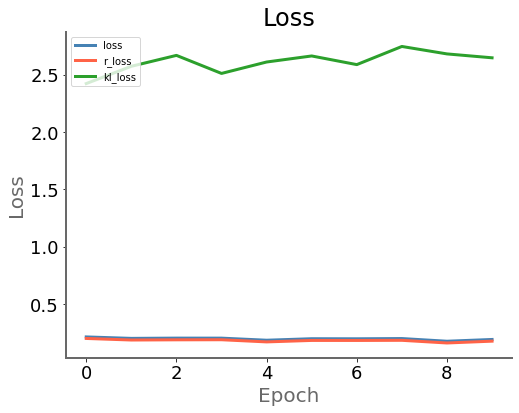

In [11]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction (input -> encoder -> decoder)

<br>**Original images :**

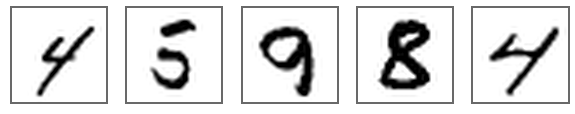

<br>**Encoded/decoded images**

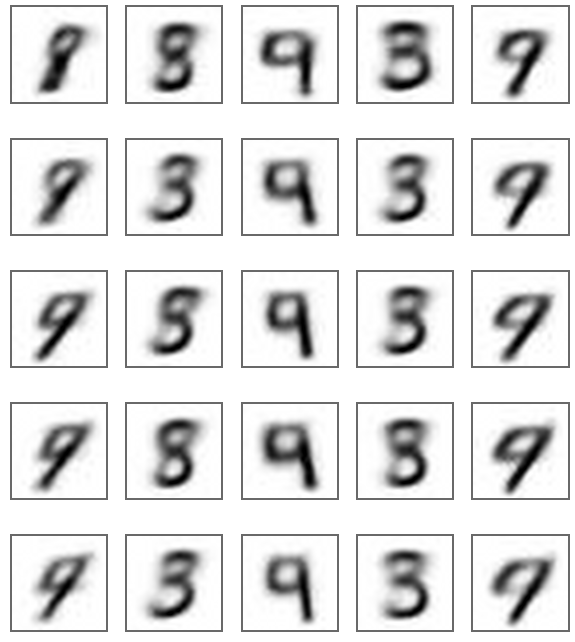

<br>**Original images :**

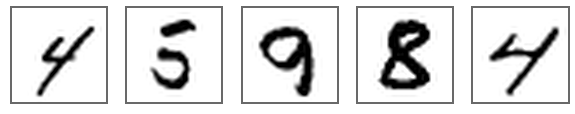

In [12]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-encoded/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder)

<br>**Generated images from latent space**

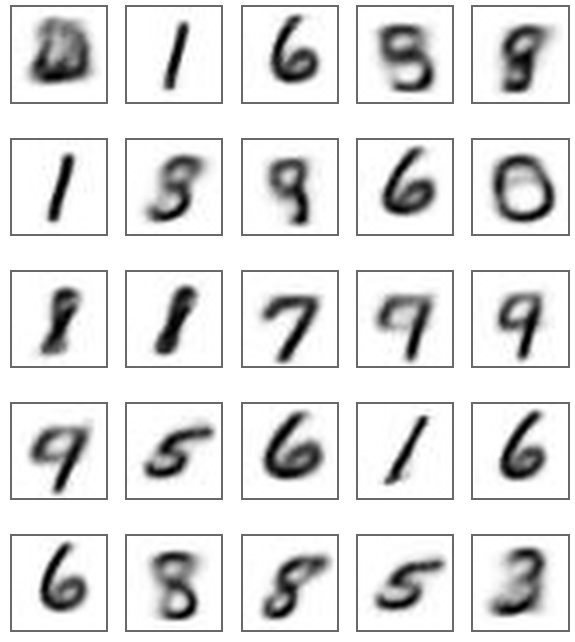

In [13]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-generated/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        
pwk.subtitle('Generated images from latent space')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-encoded')


In [14]:
pwk.end()

End time is : Wednesday 10 February 2021, 11:01:37
Duration is : 00:01:14 630ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>